In [1]:
from rdkit import Chem
import chemlib
from chemlib import Element

import numpy as np
import pandas as pd
import os
from functools import partial

from ray import train
from ray import tune
from ray.tune.schedulers import ASHAScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import global_mean_pool, GraphConv, NNConv, EdgeConv
from torch_geometric.loader import DataLoader
device = 'cuda:0'
from ray.tune.search.hyperopt import HyperOptSearch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

2025-02-20 15:22:57,072	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-20 15:22:57,253	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная процедура
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная процедура
  warnings.warn(f"An issue occurred while importi

In [2]:
path = os.path.abspath('') + '\\grouped_table.csv'

In [3]:
def load_data(abs_path = path, variable = 'Tc'):
    df = pd.read_csv(abs_path, index_col = 0)
    df = df[~df[variable].isnull()]
    df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
    quant = df[variable].quantile(q= 0.95)
    mask = df[variable] < quant
    df = df[mask]

    train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 0)
    
    valid_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 0)
    return train_df, test_df, valid_df

In [4]:
train_df, test_df, valid_df = load_data()

In [5]:
def make_edge_features(mol):
    edge_features = np.zeros([mol.GetNumBonds(), 4])
    for i, bond in enumerate(mol.GetBonds()):
        if bond.GetBondTypeAsDouble() == 1.0:
            edge_features[i,0] = 1
        elif bond.GetBondTypeAsDouble() == 2.0:
            edge_features[i,1] = 1
        elif bond.GetBondTypeAsDouble() == 3.0:
            edge_features[i, 2] = 1
        else:
            edge_features[i, 3] = 1
    return torch.tensor(edge_features, dtype = torch.float32)

In [6]:
def make_x(mol):
    atom_properties = []
    
    for atom in mol.GetAtoms():
        _el = Element(atom.GetSymbol())
        atom_properties.append([atom.GetAtomicNum(), atom.GetMass(), int(atom.GetIsAromatic()), atom.GetExplicitValence(), 
                                atom.GetImplicitValence(), atom.GetTotalValence(), 
                                atom.GetNumExplicitHs(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(),
                                atom.GetDegree(), atom.GetTotalDegree(), atom.GetFormalCharge(),
                               int(atom.IsInRing()), _el.Electronegativity, _el.FirstIonization, _el.AtomicRadius, _el.SpecificHeat
                               ])
    x = torch.tensor(atom_properties, dtype = torch.float32)
    return x

In [7]:
def make_edge_indices(mol):
    start_atoms = []
    end_atoms = []
    for bond in mol.GetBonds():
        start_atoms.append(bond.GetBeginAtomIdx())
        end_atoms.append(bond.GetEndAtomIdx())
    edge_indice = torch.tensor([start_atoms, end_atoms], dtype = torch.int64)
    return edge_indice

In [8]:
class CriticalDataset(Dataset):
    def __init__(self, frame, labels = None, transform = None, property = 'Tc'):
        super().__init__()
        self.property = property    
        self.df = frame[~frame[self.property].isnull()]
        self.labels = None
        self.transform = None
    def get(self, idx):
        mol = self.df['mol'].iloc[idx]
        #print(Chem.MolToSmiles(mol))
        try:
            x = make_x(mol)
        except:
            print('Invalid mol - cannot make x')
        try:
            edge_indices = make_edge_indices(mol)
        except:
            print('Invalid mol - cannot make edge indice')
        try:
            edge_features = make_edge_features(mol)
        except:
            print('Invalid mol - cannot make edge features')
        y = torch.tensor(self.df[self.property].iloc[idx], dtype = torch.float32)
        data = Data(x=x, edge_index=edge_indices, y = y, edge_features = edge_features)
        return data
    def len(self):
        return(len(self.df))

In [9]:
class GraphNet(nn.Module):
    def __init__(self, num_node_features = 17,
                n1 = 200,
                n2 = 500,
                n3 = 500,
                n4 = 500):
        super().__init__()
        conv_1_nn = nn.Sequential(nn.Linear(4, 200), nn.ReLU(), nn.Linear(200, 17*n1))
        self.conv_1 = NNConv(17, n1, nn = conv_1_nn)
        self.a1_con = nn.ReLU()
        
        conv_2_nn = nn.Sequential(nn.Linear(2*n1, n2), nn.ReLU(), nn.Linear(n2, n2))
        self.conv_2 = EdgeConv(nn = conv_2_nn)
        self.a2_con = nn.ReLU()
        
        conv_3_nn = nn.Sequential(nn.Linear(2*n2, n3), nn.ReLU(), nn.Linear(n3, n3))
        self.conv_3 = EdgeConv(nn = conv_3_nn)
        self.a3_con = nn.ReLU()
        
        self.conv_4 = GraphConv(in_channels = n3, out_channels = n4)
        self.a4_con = nn.ReLU()
        self.dropout_1 = nn.Dropout(p = 0.3)
        self.a1 = nn.CELU()
        self.linear_1 = nn.Linear(in_features = n4, out_features = 1000)
        self.a2 = nn.CELU()
        self.linear_2 = nn.Linear(in_features = 1000, out_features = 1000)
        self.a3 = nn.CELU()
        self.linear_3 = nn.Linear(in_features = 1000, out_features = 1)
    def forward(self, data):
        x, edge_index, edge_attrs =  (data.x, data.edge_index, data.edge_features)
        x = self.a1_con(self.conv_1(x = x, edge_index = edge_index, edge_attr = edge_attrs))
        x = self.a2_con(self.conv_2(x = x, edge_index = edge_index))
        x = self.a3_con(self.conv_3(x = x, edge_index = edge_index))
        x = self.a4_con(self.conv_4(x = x, edge_index = edge_index))
        if hasattr(data, 'batch'):
            x = global_mean_pool(x, batch = data.batch)
        else:
            x = torch.mean(x, dim = 0, keepdim = True)
        #x = self.a1(x)
        x = self.dropout_1(x)
        x = self.linear_1(x)
        x = self.a2(x)
        x = self.linear_2(x)
        x = self.a3(x)
        x = self.linear_3(x)
        return x


In [10]:
config = {
    "n1": tune.qrandint(100, 1000, 100),
    "n2": tune.qrandint(100, 1000, 100),
    "n3": tune.qrandint(100, 1000, 100),
    "n4": tune.qrandint(100, 1000, 100),
    "n_epochs": tune.qrandint(1, 50, 5),
    "lr": tune.loguniform(1e-4, 1e-2)}

In [11]:
def train_model(config = config, 
                abs_path  = path,
                variable = 'Tc',
                is_tune = True):

    train_df, test_df, valid_df = load_data(abs_path = abs_path, variable = variable)
    if is_tune:
        train_ds, test_ds,  valid_ds = (CriticalDataset(train_df, property = variable), 
                                        CriticalDataset(test_df, property = variable), 
                                        CriticalDataset(valid_df,property = variable))
        train_dl, test_dl, valid_dl = (DataLoader(train_ds, batch_size=2), DataLoader(test_ds, batch_size =2),  DataLoader(valid_ds, batch_size=2))
    else:
        train_df = pd.concat([train_df, test_df])
        train_ds, valid_ds = (CriticalDataset(train_df, property = variable), 
                              CriticalDataset(valid_df, property = variable))
        train_dl, valid_dl = (DataLoader(train_ds, batch_size = 2), DataLoader(valid_ds, batch_size = 2))
        
    model = GraphNet(n1 = config['n1'], n2 = config['n2'], n3 = config['n3'], n4 = config['n4'])
    model.to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = config['lr'])
    loss_fn = nn.MSELoss()
    for epoch in range(config['n_epochs']):
        epoch_train_loss, epoch_valid_loss, epoch_train_rmse, epoch_valid_rmse, epoch_r2_valid, total_graphs = 0, 0, 0, 0, 0, 0
        model.train()
        for batch in train_dl:
            batch.to(device)
            output = model(batch)
            loss = loss_fn(output.flatten(), batch.y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            epoch_train_rmse += (output.flatten() -batch.y).pow(2).sum().item()
            total_graphs += batch.num_graphs
            
        epoch_train_loss = epoch_train_loss / total_graphs
        epoch_train_rmse = np.sqrt(epoch_train_rmse/total_graphs)
        
        model.eval()
        total_graphs = 0
        predictions = []
        ys = []
        for batch in valid_dl:
            batch.to(device)
            output = model(batch)
            loss = loss_fn(output.flatten(), batch.y)
            epoch_valid_loss += loss.item()
            epoch_valid_rmse += (output.flatten() -batch.y).pow(2).sum().item()
            total_graphs += batch.num_graphs
            predictions.append(output)
            ys.append(batch.y)
            
        predictions = torch.cat(predictions, dim = 0).detach().cpu().numpy()
        ys = torch.cat(ys, dim = 0).detach().cpu().numpy()
        epoch_valid_loss = epoch_valid_loss / total_graphs
        epoch_valid_rmse = np.sqrt(epoch_valid_rmse / total_graphs)
        epoch_r2_valid = r2_score(ys, predictions.squeeze())
        if not is_tune:
            print('vali loss is:', epoch_valid_loss, ' valid rmse is: ', epoch_valid_rmse, ' R2 valid is ',  epoch_r2_valid)
        if is_tune:
            train.report({'train_loss':epoch_train_loss,
                          'train_rmse':epoch_train_rmse,
                          'valid_loss':epoch_valid_loss,
                          'valid_rmse':epoch_valid_rmse,
                          'r2_valid':epoch_r2_valid})
    if not is_tune:
        sns.scatterplot(x = predictions.squeeze(), y = ys)
        return model
        

C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2562.3418291640746  valid rmse is:  71.58689585621204  R2 valid is  0.4325447082519531


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2347.770996174255  valid rmse is:  68.52402492811196  R2 valid is  0.48006343841552734


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1099.7751064122497  valid rmse is:  46.899362605738034  R2 valid is  0.7564441561698914


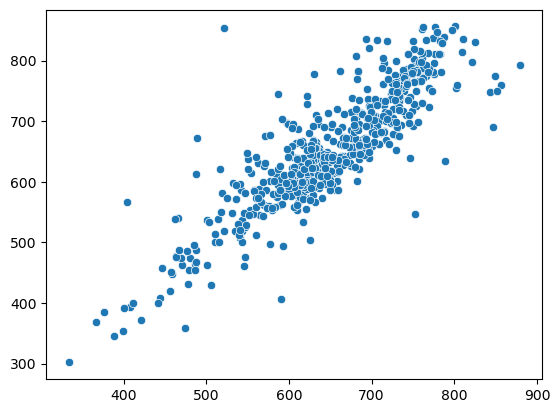

In [12]:
config = {
    "n1": 200,
    "n2": 500,
    "n3": 500,
    "n4": 500,
    "n_epochs": 3,
    "lr": 0.0001}
model = train_model(config = config, is_tune = False, variable = 'Tc')

In [13]:
config = {
    "n1": tune.qrandint(100, 1000, 100),
    "n2": tune.qrandint(100, 1000, 100),
    "n3": tune.qrandint(100, 1000, 100),
    "n4": tune.qrandint(100, 1000, 100),
    "n_epochs": tune.qrandint(1, 50, 5),
    "lr": tune.loguniform(1e-4, 1e-2)}

In [14]:
hpt_search = HyperOptSearch(metric = 'valid_loss', mode = 'min')

In [15]:
max_num_epochs = 50
scheduler = ASHAScheduler(metric = 'valid_loss', mode = 'min', max_t = max_num_epochs, grace_period= 5, reduction_factor=2)

In [16]:
result = tune.run(partial(train_model, variable = 'Tc'), search_alg = hpt_search, config = config, num_samples = 25, scheduler = scheduler, resources_per_trial={'gpu':1})

2025-02-20 15:28:04,411	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2025-02-20 15:28:07,649	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-02-20 15:28:07,652	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(pid=1740) Windows fatal exception: code 0xc0000139
(pid=1740) 
(pid=1740) Stack (most recent call first):
(pid=1740)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\ctypes\__init__.py", line 376 in __init__
(pid=1740)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch\_ops.py", line 1350 in load_library
(pid=1740)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_scatter\__init__.py", line 16 in <module>
(pid=1740)   File "<frozen importlib._bootstrap>", line 241 in _call_with_frames_removed
(pid=1740)   File "<frozen importlib._bootstrap_external>", line 940 in exec_module
(pid=1740)   File "<frozen importlib._bootstrap>", line 690 in _load_unlocked
(pid=1740)   File "<frozen importlib._bootstrap>", line 1147 in _find_and_load_unlocked
(pid=1740)   File "<frozen importlib._bootstrap>", line 1176 in _find_and_load
(pid=1740)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\typin

Trial name,r2_valid,train_loss,train_rmse,valid_loss,valid_rmse
train_model_1aa6d1cf,0.131143,3433.71,82.8699,3923.32,88.5813
train_model_1dc31a3e,-0.104597,4952.62,99.5238,4987.8,99.878
train_model_29424337,0.842147,963.822,43.9045,712.783,37.7567
train_model_38caaf38,0.81175,914.233,42.7605,850.043,41.2321
train_model_3ff390fa,0.769866,1747.13,59.1097,1039.17,45.5888
train_model_4381901e,0.31507,2994.83,77.3917,3092.8,78.6486
train_model_472056aa,0.347308,1623.42,56.9778,2947.23,76.7754
train_model_48616730,0.796902,1149.87,47.9548,917.088,42.8273
train_model_50863fe6,0.888426,401.913,28.3511,503.812,31.7431
train_model_54a2c858,0.762146,1423.99,53.3648,1074.03,46.3472


(func pid=1740) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=1740)   warnings.warn(message)
(func pid=1740) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=1740)   warnings.warn(message)
(func pid=1740) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=1740)   warnings.warn(message)
(func pid=1740) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be

In [17]:
result.dataframe()

,train_loss,train_rmse,valid_loss,valid_rmse,r2_valid,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/n1,config/n2,config/n3,config/n4,config/n_epochs,config/lr,logdir
0,661.257573,36.366285,451.564678,30.052111,0.899997,1740055455,None,False,15,54dc5fb3,...,127.0.0.1,962.306067,15,500,500,600,1000,15,0.000614,54dc5fb3
1,3433.713075,82.869935,3923.321618,88.581280,0.131143,1740055830,None,True,5,1aa6d1cf,...,127.0.0.1,368.686980,5,100,500,500,600,5,0.005582,1aa6d1cf
2,927.178317,43.061322,777.635724,39.436930,0.827785,1740056498,None,True,10,e6e42b09,...,127.0.0.1,663.046319,10,900,200,900,800,10,0.000121,e6e42b09
3,3716.080008,86.209974,3594.779049,84.791262,0.203901,1740056885,None,True,5,db8260e7,...,127.0.0.1,380.841312,5,200,400,1000,300,15,0.002829,db8260e7
4,4930.673341,99.303270,5101.436885,101.009276,-0.129762,1740057217,None,True,5,d5184209,...,127.0.0.1,326.958761,5,600,800,900,200,20,0.003958,d5184209
5,381.682786,27.628705,432.541856,29.412305,0.904209,1740059593,None,False,35,79959c43,...,127.0.0.1,2370.599046,35,500,1000,900,800,35,0.000328,79959c43
6,7047.677311,118.722593,4654.884072,96.487140,-0.030869,1740059932,None,True,5,5d0985a0,...,127.0.0.1,332.092637,5,300,600,700,900,50,0.007241,5d0985a0
7,1747.133480,59.109736,1039.168747,45.588787,0.769866,1740060611,None,True,10,3ff390fa,...,127.0.0.1,673.327839,10,800,800,800,200,15,0.001083,3ff390fa
8,3243.088166,80.536330,3033.283470,77.888169,0.328250,1740060996,None,True,5,b3c0253c,...,127.0.0.1,379.640361,5,200,900,200,400,20,0.008507,b3c0253c
9,5000.573896,100.004358,4935.011096,99.347985,-0.092906,1740061387,None,True,5,a7fe306c,...,127.0.0.1,385.187315,5,500,300,500,200,50,0.007742,a7fe306c


In [20]:
with open('temperature_result.pickle', 'wb') as out:
    pickle.dump(result, out)

In [21]:
best_config = result.get_best_config(metric = 'valid_rmse', mode = 'min')
print(best_config)
with open('best_config_temperature.pickle', 'wb') as out:
    pickle.dump(best_config, out)

{'n1': 500, 'n2': 1000, 'n3': 900, 'n4': 800, 'n_epochs': 35, 'lr': 0.0003281467852249796}


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2645.8442720199946  valid rmse is:  72.74399318184278  R2 valid is  0.41405218839645386


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 6511.135106990864  valid rmse is:  114.11516206877037  R2 valid is  -0.44195377826690674


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1934.0799433426423  valid rmse is:  62.19453261087573  R2 valid is  0.5716793537139893


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1308.0166482747375  valid rmse is:  51.14717290867087  R2 valid is  0.7103270888328552


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1168.3818820765266  valid rmse is:  48.340084445034364  R2 valid is  0.7412505149841309


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1076.2114065075323  valid rmse is:  46.39421098601704  R2 valid is  0.7616626024246216


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1016.0739545695387  valid rmse is:  45.079351250201874  R2 valid is  0.7749806046485901


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1064.6253470337235  valid rmse is:  46.143804503610745  R2 valid is  0.7642284035682678


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 773.8119319669612  valid rmse is:  39.33985083771827  R2 valid is  0.8286318778991699


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 915.2856832793007  valid rmse is:  42.7851769490159  R2 valid is  0.797301173210144


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 523.1896521417883  valid rmse is:  32.34778669837515  R2 valid is  0.8841345906257629


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 727.4916879910153  valid rmse is:  38.14424433623021  R2 valid is  0.8388899564743042


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 520.0052890452472  valid rmse is:  32.24919499910803  R2 valid is  0.8848398327827454


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 618.7718276582029  valid rmse is:  35.178738682852256  R2 valid is  0.8629670143127441


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 518.5574579329847  valid rmse is:  32.20426859697282  R2 valid is  0.8851604461669922


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 482.7341476849147  valid rmse is:  31.07198570046384  R2 valid is  0.8930938243865967


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 474.5159731073813  valid rmse is:  30.806362106142338  R2 valid is  0.8949138522148132


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 463.5613584324911  valid rmse is:  30.4486899039184  R2 valid is  0.8973398804664612


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 564.129804117339  valid rmse is:  33.589575886496064  R2 valid is  0.8750680088996887


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 557.9398866351452  valid rmse is:  33.40478668200547  R2 valid is  0.8764388561248779


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 519.9097510299513  valid rmse is:  32.246232369997934  R2 valid is  0.8848609328269958


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 464.71951790270094  valid rmse is:  30.48670260630693  R2 valid is  0.8970833420753479


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 441.29106493623226  valid rmse is:  29.708283859429923  R2 valid is  0.9022718071937561


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 462.47386612830223  valid rmse is:  30.412953362943963  R2 valid is  0.8975806832313538


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 452.67452849002626  valid rmse is:  30.08901887699319  R2 valid is  0.899750828742981


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 526.4894235610581  valid rmse is:  32.44963554683036  R2 valid is  0.8834038376808167


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 424.4192991955327  valid rmse is:  29.13483479258232  R2 valid is  0.906008243560791


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 406.1271570446816  valid rmse is:  28.500075685677807  R2 valid is  0.9100592136383057


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 438.8438659954768  valid rmse is:  29.625795044031367  R2 valid is  0.9028137922286987


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 410.2734634478867  valid rmse is:  28.64519029253905  R2 valid is  0.9091410040855408


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 367.45719725986964  valid rmse is:  27.109304574624176  R2 valid is  0.9186230301856995


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 390.6890995503923  valid rmse is:  27.953142919907677  R2 valid is  0.9134781360626221


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 419.4494156663294  valid rmse is:  28.963750298134023  R2 valid is  0.9071089029312134


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 361.9377472907208  valid rmse is:  26.904934390952185  R2 valid is  0.9198454022407532


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 392.0399271079472  valid rmse is:  28.001425931832372  R2 valid is  0.9131789803504944


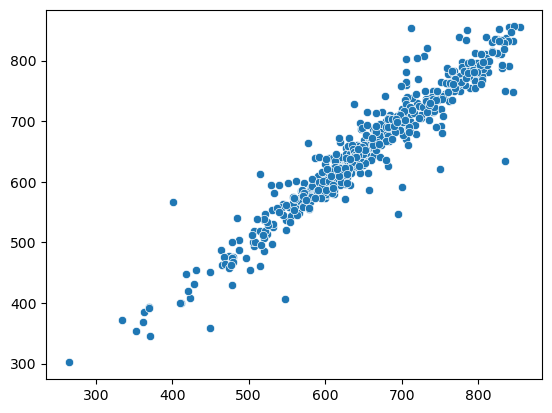

In [22]:
model = train_model(config = best_config, variable = 'Tc', is_tune = False)

In [23]:
torch.save(model, 'temperature_model.pth')